<a href="https://colab.research.google.com/github/gecco-evojax/evojax/blob/main/notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan  6 11:12:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |      0MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# @title Install Packages

from IPython.display import clear_output

!pip install --upgrade pip
!pip install --upgrade "jaxlib[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install torchvision
!pip install git+https://github.com/gecco-evojax/evojax.git@main

clear_output()

In [3]:
# @title Import Libraries

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import jax
import jax.numpy as jnp
from jax import random

from evojax import SimManager
from evojax import Trainer
from evojax.algo import PGPE
from evojax.policy import ConvnetPolicy
from evojax.task.mnist import MNIST

In [4]:
# @title Confirm JAX Backend

print('jax backend: {}'.format(jax.devices()))
print('You need to restart the runtime if the output above is not GPU')

jax backend: [GpuDevice(id=0, process_index=0)]
You need to restart the runtime if the output above is not GPU


# Learning MNIST Classification

In training the scores are cross-entropy losses, and in tests the scores are accuracies.

In [5]:
# @title Set hyper-paramters
pop_size = 64  # @param
center_lr = 0.006  # @param
stdev_lr = 0.089  # @param
init_stdev = 0.039  #@param
seed = 0  # @param
batch_size = 1024 # @param
time_limit = 300  # @param
test_interval = 500 # @param

In [6]:
# @title Training

policy = ConvnetPolicy()
print('#params={}'.format(policy.num_params))

train_task = MNIST(batch_size=batch_size, test=False)
test_task = MNIST(batch_size=batch_size, test=True)

sim_mgr = SimManager(
    n_repeats=1,
    test_n_repeats=1,
    pop_size=pop_size,
    n_evaluations=1,
    policy_net=policy,
    train_vec_task=train_task,
    valid_vec_task=test_task,
    seed=seed,
)
solver = PGPE(
    pop_size=pop_size,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=center_lr,
    stdev_learning_rate=stdev_lr,
    init_stdev=init_stdev,
    seed=seed,
)


print('Start training MNIST for {} seconds'.format(time_limit))
    
start_time = time.perf_counter()
train_iters = 0
test_time_cost = 0
while time.perf_counter() - start_time - test_time_cost < time_limit:
  
  # Training.
  params = solver.ask()
  scores = sim_mgr.eval_params(params=params, test=False)
  solver.tell(fitness=scores)
  train_iters += 1

  # Test periodically.
  if train_iters > 0 and train_iters % test_interval == 0:
    test_start_time = time.perf_counter()
    best_params = solver.best_params
    scores = np.array(sim_mgr.eval_params(params=best_params, test=True))
    score_avg = np.mean(scores)
    score_std = np.std(scores)
    print('Iter={0}, score.avg={1:.4f}, score.std={2:.4f}'.format(
        train_iters, score_avg, score_std))
    test_time_cost += time.perf_counter() - test_start_time

# Final test.
best_params = solver.best_params
scores = np.array(sim_mgr.eval_params(params=best_params, test=True))
score_avg = np.mean(scores)
score_std = np.std(scores)
print('Iter={0}, score.avg={1:.4f}, score.std={2:.4f}'.format(
    train_iters, score_avg, score_std))

0.6%

#params=11274


100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


102.8%
0.6%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


112.7%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Start training MNIST for 300 seconds
Iter=500, score.avg=0.9362, score.std=0.0000
Iter=1000, score.avg=0.9595, score.std=0.0000
Iter=1500, score.avg=0.9658, score.std=0.0000
Iter=2000, score.avg=0.9732, score.std=0.0000
Iter=2500, score.avg=0.9758, score.std=0.0000
Iter=3000, score.avg=0.9775, score.std=0.0000
Iter=3500, score.avg=0.9795, score.std=0.0000
Iter=4000, score.avg=0.9793, score.std=0.0000
Iter=4500, score.avg=0.9795, score.std=0.0000
Iter=5000, score.avg=0.9807, score.std=0.0000
Iter=5500, score.avg=0.9810, score.std=0.0000
Iter=6000, score.avg=0.9824, score.std=0.0000
Iter=6500, score.avg=0.9829, score.std=0.0000
Iter=7000, score.avg=0.9842, score.std=0.0000
Iter=7194, score.avg=0.9843, score.std=0.0000


ground truth: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
predictions: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]


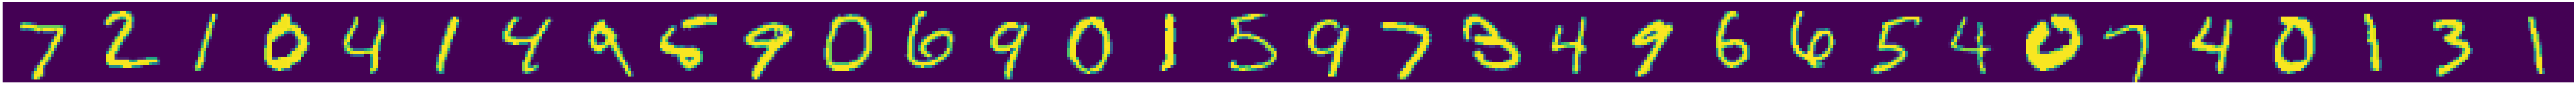

In [7]:
# @title Visualization

reset_fn = jax.jit(test_task.reset)
action_fn = jax.jit(policy.get_actions)

best_params = solver.best_params[None, :]

key = random.PRNGKey(0)
s = reset_fn(key[None, :])
predictions = action_fn(s.obs, best_params)
predicted_classes = jnp.argmax(predictions, axis=-1)

num_images = 32
print('ground truth: {}'.format(s.labels.ravel()[:num_images]))
print('predictions: {}'.format(predicted_classes.ravel()[:num_images]))

imgs = np.array(s.obs[0, :num_images] * 255).astype(np.uint8).squeeze()
imgs = imgs.transpose([1, 0, 2]).reshape((28, -1))

fig, ax = plt.subplots(1, 1, figsize=(4 * num_images, 4))
ax.imshow(imgs)
ax.set_axis_off()